In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [ ]:
print('parsing the dataset .tsv file')
comments=pd.read_csv('attack_annotated_comments.tsv', sep='\t', index_col=0)
annotations=pd.read_csv('attack_annotations.tsv', sep='\t')
print('  Done.')

parsing the dataset .tsv file
  Done.


In [ ]:
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [ ]:
comments[['comment','split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [ ]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [ ]:
labels=annotations.groupby('rev_id')['attack'].mean()>0.5
comments['attack']=labels

In [ ]:

comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [ ]:
train_comments=comments.query("split=='train'")
test_comments=comments.query("split=='test'") 

In [ ]:
comments.query('attack')['comment'].head()

rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      ____ fuck off you little asshole. If you wan...
4632658         i have a dick, its bigger than yours! hahaha
6545332      == renault ==  you sad little bpy for drivin...
6545351      == renault ==  you sad little bo for driving...
Name: comment, dtype: object

In [ ]:
total_comments=len(comments)
num_attacks=len(comments.query('attack'))
print(f"{num_attacks} of {total_comments} comments are attacks {num_attacks*100/total_comments}%")

13590 of 115864 comments are attacks 11.729268797900987%


In [ ]:
from transformers import BertTokenizer
print('loading BertTokenizer...')
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_caser=True)
print("Done")

loading BertTokenizer...
Done


In [ ]:
text=train_comments.iloc[0].comment
tokens=tokenizer.tokenize(text)
print(f'comment contains {len(tokens)}')
print(text)

comment contains 591
`- This is not ``creative``.  Those are the dictionary definitions of the terms ``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you don't understand that, fine, legitimate criticism, I'll write up ``three man cell`` and ``bounty hunter`` and then it will be easy to understand why ``ensured`` and ``insured`` are different - and why both differ from ``assured``.  The sentence you quote is absolutely neutral.  You just aren't familiar with the underlying theory of strike-back (e.g. submarines as employed in nuclear warfare) guiding the insurance, nor likely the three man cell structure that kept the IRA from being broken by the British.  If that's my fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or ``creative`` about it.  I'm tired of arguing with you.  Re: the other article, ``multi-party`` turns up plenty, and there is more use of ``mutually`` than ``mutual``.  If I were to apply your standard I'd be moving ``M

In [ ]:
print(str(text[:512]))
print(str(text[512:]))

`- This is not ``creative``.  Those are the dictionary definitions of the terms ``insurance`` and ``ensurance`` as properly applied to ``destruction``.  If you don't understand that, fine, legitimate criticism, I'll write up ``three man cell`` and ``bounty hunter`` and then it will be easy to understand why ``ensured`` and ``insured`` are different - and why both differ from ``assured``.  The sentence you quote is absolutely neutral.  You just aren't familiar with the underlying theory of strike-back (e.g. 
submarines as employed in nuclear warfare) guiding the insurance, nor likely the three man cell structure that kept the IRA from being broken by the British.  If that's my fault, fine, I can fix that to explain.  But ther'es nothing ``personal`` or ``creative`` about it.  I'm tired of arguing with you.  Re: the other article, ``multi-party`` turns up plenty, and there is more use of ``mutually`` than ``mutual``.  If I were to apply your standard I'd be moving ``Mutual Assured Destru

In [ ]:
import numpy as np 
input_ids=[]
lengths=[]
print('Tokenizing comments...')
for s in train_comments.comment:
  if(len(input_ids)%20000==0):
    print(f'read {len(input_ids)} comments')
  encoded_sen=tokenizer.encode(s,add_special_tokens=True)
  input_ids.append(encoded_sen)
  lengths.append(len(encoded_sen))

Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1090 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
read 0 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (595 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1059 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (879 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

read 20000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (961 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (685 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (528 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1076 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

read 40000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2056 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2039 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

read 60000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1004 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1400 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [ ]:
labels=train_comments.attack.to_numpy().astype(int)

In [ ]:
print(f"min length: {min(lengths)}, max length: {max(lengths)}, median length: {np.median(lengths)}")


min length: 2, max length: 9861, median length: 52.0


Text(0, 0.5, 'No. of Comments')

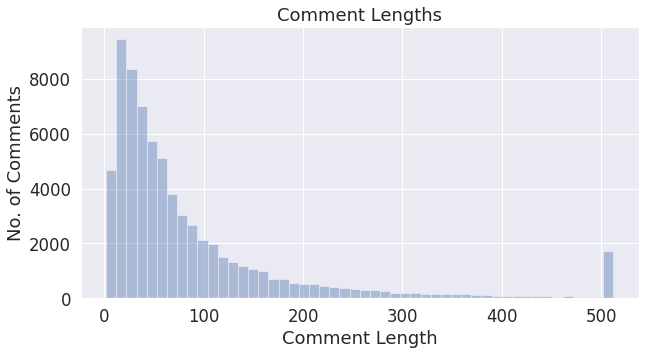

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize']=(10,5)

lengths=[ min(l, 512) for l in lengths]

sns.distplot(lengths,kde=False,rug=False)
plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('No. of Comments')

In [ ]:
num_truncated=lengths.count(512)
num_sentences=len(lengths)
prcnt=float(num_truncated)/num_sentences
print(f"{prcnt}% sentences in the training set are longer than 512 tokens")

0.0239910249403101% sentences in the training set are longer than 512 tokens


In [ ]:
from keras.preprocessing.sequence import pad_sequences
max_len=128
input_ids=pad_sequences(input_ids,maxlen=max_len,dtype='long',value=0,truncating='post',padding='post')

In [ ]:
attention_masks=[]
for s in input_ids:
  att_mask=[int(token_id>0) for token_id in s]
  attention_masks.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs,validation_inputs,train_labels,validation_labels=train_test_split(input_ids,labels,random_state=2018,test_size=0.1)
train_masks,validation_masks,_,_=train_test_split(attention_masks,labels,random_state=2018,test_size=0.1)

In [ ]:
import torch
train_inputs=torch.tensor(train_inputs)
validation_inputs=torch.tensor(validation_inputs)
train_labels=torch.tensor(train_labels)
validation_labels=torch.tensor(validation_labels)
train_masks=torch.tensor(train_masks)
validation_masks=torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,SequentialSampler
batch_size=32
train_data=TensorDataset(train_inputs,train_masks,train_labels)
train_sampler=RandomSampler(train_data)
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data=TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler=RandomSampler(validation_data)
validation_dataloader=DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model=BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,output_attentions=False,output_hidden_states=False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer=AdamW(model.parameters(),lr=2e-5,eps=1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs=4
total_steps=len(train_dataloader)*epochs
scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [ ]:
def flat_accuracy(preds,labels):
  pred_flat=np.argmax(preds,axis=1).flatten()
  labels_flat=labels.flatten()
  return np.sum(pred_flat==labels_flat)/len(labels_flat)

In [ ]:
import time 
import datetime

def format_time(elapsed):
  elapsed_rounded=int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#training_loop
import torch
import random
seed_val=42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda")
loss_values=[]

for i in range(0,epochs):
  print(f"Epoch: {i+1}/{epochs}")
  t0=time.time()
  total_loss=0
  model.train()
  for step,batch in enumerate(train_dataloader):
    if step%100==0 and not step ==0:
      elapsed=format_time(time.time()-t0)
      print(f"Batch {step} of {len(train_dataloader)}, Elapsed: {elapsed}")
    b_input_ids=batch[0].to(device)
    b_input_masks=batch[1].to(device)
    b_labels=batch[2].to(device)

    model.zero_grad()

    outputs=model(b_input_ids,token_type_ids=None,attention_mask=b_input_masks,labels=b_labels)

    loss=outputs[0]
    total_loss+=loss.item()
    loss.backward()

    torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

    optimizer.step()
    scheduler.step()
  
  avg_train_loss=total_loss/len(train_dataloader)

  loss_values.append(avg_train_loss)
  print(f"Avg training loss:{avg_train_loss} , training epoch took:{format_time(time.time()-t0)}")

  t0=time.time()

  model.eval()

  eval_loss,eval_accuracy=0,0
  nb_eval_steps,nb_eval_accuracy=0,0

  for batch in validation_dataloader:
    batch= tuple(t.to(device) for t in batch)
    b_input_ids,b_input_masks,b_labels=batch

    with torch.no_grad():
      outputs=model(b_input_ids,token_type_ids=None,attention_mask=b_input_masks)
    
    logits=outputs[0]

    logits=logits.detach().cpu().numpy()
    label_ids=b_labels.to('cpu').numpy()

    tmp_eval_accuracy=flat_accuracy(logits,label_ids)
    eval_accuracy+=tmp_eval_accuracy
    nb_eval_steps+=1

  print(f"Accuracy:{eval_accuracy/nb_eval_steps} , training epoch took:{format_time(time.time()-t0)}")

print('Training complete')

Epoch: 1/4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Batch 100 of 1956, Elapsed: 0:00:38
Batch 200 of 1956, Elapsed: 0:01:17
Batch 300 of 1956, Elapsed: 0:01:55
Batch 400 of 1956, Elapsed: 0:02:33
Batch 500 of 1956, Elapsed: 0:03:12
Batch 600 of 1956, Elapsed: 0:03:50
Batch 700 of 1956, Elapsed: 0:04:28
Batch 800 of 1956, Elapsed: 0:05:07
Batch 900 of 1956, Elapsed: 0:05:45
Batch 1000 of 1956, Elapsed: 0:06:24
Batch 1100 of 1956, Elapsed: 0:07:02
Batch 1200 of 1956, Elapsed: 0:07:40
Batch 1300 of 1956, Elapsed: 0:08:19
Batch 1400 of 1956, Elapsed: 0:08:57
Batch 1500 of 1956, Elapsed: 0:09:35
Batch 1600 of 1956, Elapsed: 0:10:14
Batch 1700 of 1956, Elapsed: 0:10:52
Batch 1800 of 1956, Elapsed: 0:11:31
Batch 1900 of 1956, Elapsed: 0:12:09
Avg training loss:0.13951640300167503 , training epoch took:0:12:30
Accuracy:0.9540488022426096 , training epoch took:0:00:27
Epoch: 2/4
Batch 100 of 1956, Elapsed: 0:00:38
Batch 200 of 1956, Elapsed: 0:01:17
Batch 300 of 1956, Elapsed: 0:01:55
Batch 400 of 1956, Elapsed: 0:02:34
Batch 500 of 1956, Elapse

In [ ]:
test_input_ids=[]

print('Tokenizing comments...')
for s in train_comments.comment:
  if(len(input_ids)%20000==0):
    print(f'read {len(input_id)} comments')
  encoded_sen=tokenizer.encode(s,add_special_tokens=True,max_length=max_len)
  test_input_ids.append(encoded_sen)


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Tokenizing comments...


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

In [ ]:
test_labels=test_comments.attack.to_numpy().astype(int)
test_input_ids=pad_sequences(test_input_ids,maxlen=max_len,dtype='long',value=0,truncating='post',padding='post')
test_attention_masks=[]
for s in test_input_ids:
  seq_mask=[float(i>0) for i in s]
  test_attention_masks.append(seq_mask)


In [ ]:
test_inputs=torch.tensor(test_inputs_ids)
test_labels=torch.tensor(test_labels)
test_masks=torch.tensor(test_masks)

batch_size=32
test_data=TensorDataset(test_inputs,test_masks,test_labels)
test_sampler=RandomSampler(test_data)
test_dataloader=DataLoader(test_data,sampler=test_sampler,batch_size=batch_size)

In [ ]:
model.eval()
predictions,true_labels=[],[]

t0=time.time()
for step,batch in enumerate(train_dataloader):
  batch= tuple(t.to(device) for i in batch)
  if step%100==0 and not step ==0:
    elapsed=format_time(time.time()-t0)
    print(f"Batch {step} of {len(train_dataloader)}, Elapsed: {elapsed}")
 
  b_input_ids,b_input_masks,b_labels=batch
  
  with torch.no_grad():
    outputs=model(b_input_ids,token_type_ids=None,attention_masks=b_input_masks)
    
  logits=outputs[0]

  logits=logits.detach().cpu().numpy()
  label_ids=b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('Done')

In [ ]:
predictions=np.concatenate(predictions,axis=0)
true_labels=np.concatenate(true_labels,axis=0)

In [ ]:
from sklearn.metrics import roc_auc_score

p1=predictions[:,1]
auc=roc_auc_score(true_labels,p1)

print(f'Test ROC AUC:{auc}%')